<a href="https://colab.research.google.com/github/MontyRajSingh/Pateint-Risk-Startification-System/blob/main/Pateint_Risk_Startification_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Load data (MIMIC-III)
patients = pd.read_csv('PATIENTS.csv', usecols=['subject_id', 'gender', 'dob'])
admissions = pd.read_csv('ADMISSIONS.csv', usecols=['subject_id', 'hadm_id', 'admittime', 'hospital_expire_flag'])
icu_stays = pd.read_csv('ICUSTAYS.csv', usecols=['hadm_id', 'icustay_id', 'intime', 'outtime', 'los'])
chart_events = pd.read_csv('CHARTEVENTS.csv', low_memory=False)  # Handle mixed dtypes

# Merge patient and admission data
patient_admissions = pd.merge(patients, admissions, on='subject_id')

# Merge with ICU stays
icu_data = pd.merge(patient_admissions, icu_stays, on='hadm_id')

# Calculate age (year difference)
icu_data['dob_year'] = pd.to_datetime(icu_data['dob'], errors='coerce').dt.year
icu_data['admit_year'] = pd.to_datetime(icu_data['admittime'], errors='coerce').dt.year
icu_data['age'] = (icu_data['admit_year'] - icu_data['dob_year']).clip(18, 100)

# Encode gender
icu_data['gender'] = icu_data['gender'].map({'F': 0, 'M': 1})

# Filter CHARTEVENTS for first 24h of ICU stay
chart_events['charttime'] = pd.to_datetime(chart_events['charttime'], errors='coerce')
icu_data['intime'] = pd.to_datetime(icu_data['intime'], errors='coerce')

chart_events_24h = pd.merge(
    chart_events,
    icu_data[['icustay_id', 'intime']],
    on='icustay_id'
)
chart_events_24h = chart_events_24h[
    (chart_events_24h['charttime'] >= chart_events_24h['intime']) &
    (chart_events_24h['charttime'] <= chart_events_24h['intime'] + pd.Timedelta(hours=24))
]

# Aggregate max heart rate (ITEMID=211)
heart_rate = chart_events_24h[chart_events_24h['itemid'] == 211]
heart_rate_agg = heart_rate.groupby('icustay_id')['valuenum'].max().reset_index(name='max_heart_rate')

# Merge features
final_data = pd.merge(icu_data, heart_rate_agg, on='icustay_id', how='left')
final_data['max_heart_rate'] = final_data['max_heart_rate'].fillna(final_data['max_heart_rate'].median())

print(final_data.head())

   subject_id  gender                  dob  hadm_id            admittime  \
0       10006       0  2094-03-05 00:00:00   142345  2164-10-23 21:09:00   
1       10011       0  2090-06-05 00:00:00   105331  2126-08-14 22:32:00   
2       10013       0  2038-09-03 00:00:00   165520  2125-10-04 23:36:00   
3       10017       0  2075-09-21 00:00:00   199207  2149-05-26 17:19:00   
4       10019       1  2114-06-20 00:00:00   177759  2163-05-14 20:43:00   

   hospital_expire_flag  icustay_id              intime              outtime  \
0                     0      206504 2164-10-23 21:10:15  2164-10-25 12:21:07   
1                     1      232110 2126-08-14 22:34:00  2126-08-28 18:59:00   
2                     1      264446 2125-10-04 23:38:00  2125-10-07 15:13:52   
3                     0      204881 2149-05-29 18:52:29  2149-05-31 22:19:17   
4                     1      228977 2163-05-14 20:43:56  2163-05-16 03:47:04   

       los  dob_year  admit_year  age  max_heart_rate  
0   1.

In [ ]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = final_data[['age', 'gender', 'max_heart_rate', 'los']]
y = final_data['hospital_expire_flag']  # Mortality label

# Split data (stratified to handle class imbalance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report

# Initialize model (adjust for class imbalance)
model = XGBClassifier(
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),  # Handle imbalance
    objective='binary:logistic',
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42
)

# Train the model
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

AUC: 0.88


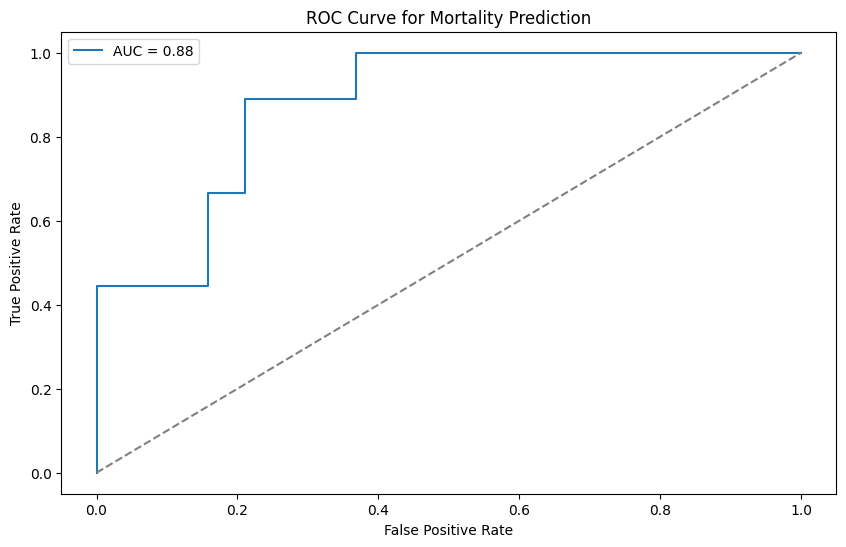

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Predict probabilities
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc:.2f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Mortality Prediction')
plt.legend()
plt.show()

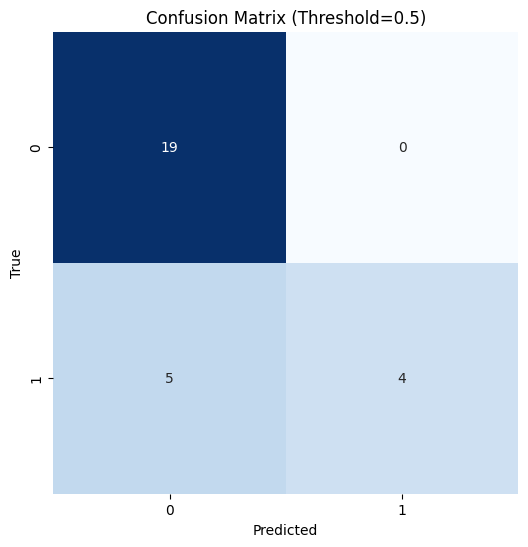

              precision    recall  f1-score   support

           0       0.79      1.00      0.88        19
           1       1.00      0.44      0.62         9

    accuracy                           0.82        28
   macro avg       0.90      0.72      0.75        28
weighted avg       0.86      0.82      0.80        28



In [ ]:
# Convert probabilities to binary predictions (threshold=0.5)
y_pred = (y_pred_proba > 0.5).astype(int)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Threshold=0.5)')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred))

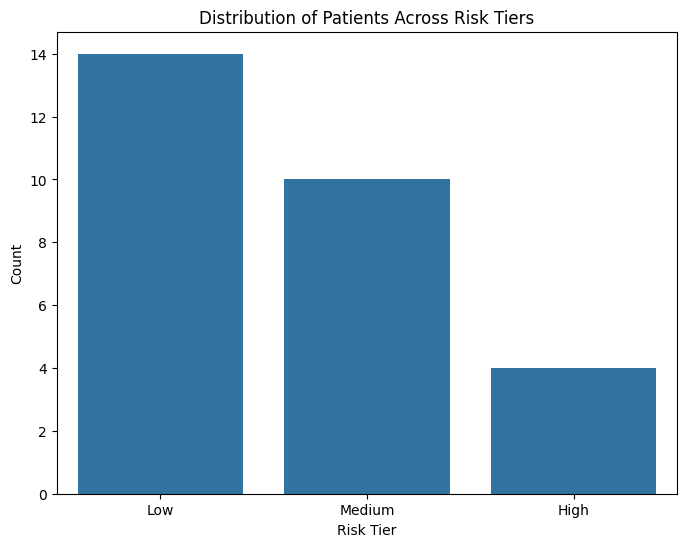

In [ ]:
# Assign risk tiers based on probabilities
risk_tiers = pd.cut(
    y_pred_proba,
    bins=[0, 0.2, 0.5, 1],
    labels=['Low', 'Medium', 'High'],
    include_lowest=True
)

# Add to test data
test_results = X_test.copy()
test_results['mortality_prob'] = y_pred_proba
test_results['risk_tier'] = risk_tiers

# Plot risk tier distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='risk_tier', data=test_results, order=['Low', 'Medium', 'High'])
plt.title('Distribution of Patients Across Risk Tiers')
plt.xlabel('Risk Tier')
plt.ylabel('Count')
plt.show()

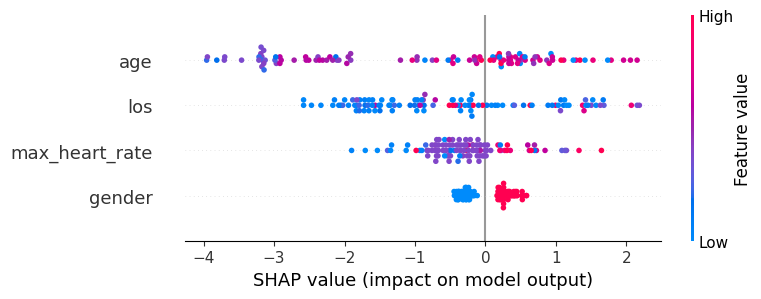

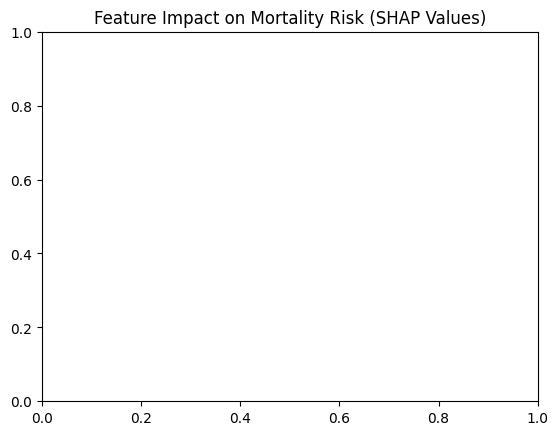

In [ ]:
import shap

# Explain model predictions
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# Plot feature importance
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, X_train, feature_names=X.columns)
plt.title('Feature Impact on Mortality Risk (SHAP Values)')
plt.show()